In [7]:
%pip install pybids

     |████████████████████████████████| 4.0MB 11.1MB/s eta 0:00:01
     |████████████████████████████████| 102kB 4.2MB/s eta 0:00:01
     |████████████████████████████████| 6.0MB 22.6MB/s eta 0:00:01
  Created wheel for sqlalchemy: filename=SQLAlchemy-1.3.10-cp37-cp37m-linux_x86_64.whl size=1187710 sha256=0b7843fe5f1c5abcabbd415a3151db4a638480f22e15121d2799f0d4aa1077c9
  Stored in directory: /home/campcc/.cache/pip/wheels/4b/b2/89/cd2231ee623987c605f049df55f40a3e4252ef6a15b94836c2
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=c026bc06e1887ef1870b8a41429f1496cb639d95e6d5b6e1f16b50b0b3432849
  Stored in directory: /home/campcc/.cache/pip/wheels/9b/04/dd/7daf4150b6d9b12949298737de9431a324d4b797ffd63f526e
Successfully built sqlalchemy docopt
Note: you may need to restart the kernel to use updated packages.


In [1]:
#quickstart
from pathlib import Path
import pandas as pd
from bids import BIDSLayout
from joblib import Parallel, delayed
import nilearn
import nibabel as nib
import nltools.prefs as prf
from nilearn import datasets, image, plotting, input_data
from nilearn.masking import apply_mask
from nilearn.image import resample_to_img
from nilearn.image import concat_imgs, index_img
import numpy as np
import matplotlib.pylab as plt

import os
import glob
import seaborn as sns
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import zscore
from scipy.stats import binom, ttest_1samp
from sklearn.metrics import pairwise_distances
from nltools.stats import fdr, one_sample_permutation
from copy import deepcopy
from nltools.utils import get_anatomical
import nltools.plotting as nlplt
from datetime import date
from joblib import Parallel, delayed

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA


dat_paths = pd.read_csv('/data/MBDU/midla/notebooks/campcc/dat_paths_111919.csv') 
atlas = image.load_img('/data/MBDU/midla/notebooks/campcc/hox_msdl_atlas.nii.gz')
#sub1 = image.load_img('/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-20900/out/fmriprep/sub-20900/ses-01/func/sub-20900_ses-01_task-mid_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')

/gpfs/gsfs11/users/MBDU/midla/env/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
#outdated
from pathlib import Path
import pandas as pd
from bids import BIDSLayout
from joblib import Parallel, delayed
import nilearn
import nibabel as nib
import nltools.prefs as prf
from nilearn import datasets, image, plotting, input_data
from nilearn.masking import apply_mask
from nilearn.image import resample_to_img
from nilearn.image import concat_imgs, index_img
import numpy as np
import matplotlib.pylab as plt

import os
import glob
import seaborn as sns
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import zscore
from scipy.stats import binom, ttest_1samp
from sklearn.metrics import pairwise_distances
from nltools.stats import fdr, one_sample_permutation
from copy import deepcopy
from nltools.utils import get_anatomical
import nltools.plotting as nlplt
from datetime import date
from joblib import Parallel, delayed

In [82]:
today = date.today()
today_str = today.strftime("%m%d%y")

In [2]:
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.width', 1000)

from IPython.core.display import display, HTML
display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } " 
    + ".container { width:100% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

In [28]:
project_root = Path('/data/MBDU/midla')
bids_dir = project_root / 'data/bids'
derivatives_dir = project_root / 'data/derivatives'
fmriprep_run_name = 'rn_aroma_20190910_2mm'
fmriprep_out = derivatives_dir / 'fmriprep' / fmriprep_run_name
fitlins_run_name = 'nobutton_extras_nobsl_reml_2mm_strict'
fitlins_out = derivatives_dir / 'fitlins' / fitlins_run_name
dm = '/data/MBDU/midla/notebooks/design_paths_nobutton_extras_nobsl_reml_2mm_strict.csv'


In [75]:
# the following command takes about 30 minutes
layout = BIDSLayout(bids_dir, derivatives=fmriprep_out)
subjects = layout.get_subjects()
sessions = layout.get_sessions()
runs = layout.get_runs()

In [52]:
layout_df = layout.to_df()
layout_df.to_csv('layout_11082019.csv')

In [87]:
space='MNI152NLin2009cAsym'
task='mid'
verbose=True

#cfd_pattern = 'sub-{subject}/out/fmriprep/sub-{subject}/ses-{session}/func/sub-{subject}_ses-{session}_task-{task}_run-{run}_desc-{desc}_{suffix}.{extension}'
cfd_pattern = 'sub-{subject}/ses-{session}/run-{run}/out/out/fitlins/sub-{subject}/ses-{session}/sub-{subject}_ses-{session}_task-{task}_run-{run}_design.{extension}'
img_pattern = 'sub-{subject}/out/fmriprep/sub-{subject}/ses-{session}/func/sub-{subject}_ses-{session}_task-{task}_run-{run}_space-{space}_desc-{desc}_{suffix}.{extension}'
event_pattern = 'sub-{subject}/ses-{session}/func/sub-{subject}_ses-{session}_task-{task}_run-{run}_{suffix}.{extension}'
gm_mask_pattern = 'sub-{subject}/out/fmriprep/sub-{subject}/anat/sub-{subject}_space-{space}_label-GM_probseg.{extension}'
dat_paths = []
for subj in subjects:
    if verbose:
        print(subj, end=', ')
    for ses in sessions:
        for rn in runs:
            run_ents = dict(subject=subj, 
                        session=ses,
                        run=rn,
                        task=task)
            try:
                cfd_ents = run_ents.copy()
                cfd_ents.update({'extension':'tsv'})
                cfd_file = fitlins_out / layout.build_path(cfd_ents,cfd_pattern, validate=False)
                if not cfd_file.exists():
                    raise FileNotFoundError(cfd_file.as_posix())

                img_ents = run_ents.copy()
                img_ents.update({'desc':'preproc', 'suffix':'bold', 'extension':'nii.gz', 'space':space})
                img_file = fmriprep_out / layout.build_path(img_ents,img_pattern, validate=False)
                if not img_file.exists():
                    raise FileNotFoundError(img_file.as_posix())

                scl_ents = run_ents.copy()
                scl_ents.update({'desc':'scale', 'suffix':'bold', 'extension':'nii.gz', 'space':space})
                scl_file = fmriprep_out / layout.build_path(scl_ents,img_pattern, validate=False)
                if not scl_file.exists():
                    raise FileNotFoundError(scl_file.as_posix())

                mask_ents = run_ents.copy()
                mask_ents.update({'extension':'nii.gz', 'space':space})
                mask_file = fmriprep_out / layout.build_path(mask_ents,gm_mask_pattern, validate=False)
                if not mask_file.exists():
                    raise FileNotFoundError(mask_file.as_posix())

                run_ents['confounds_path'] = cfd_file.as_posix()
                run_ents['image_path'] = img_file.as_posix()
                run_ents['scaled_path'] = scl_file.as_posix()
                run_ents['mask_path'] = mask_file.as_posix()

                dat_paths.append(run_ents)

            except FileNotFoundError:
                pass

dat_paths = pd.DataFrame(dat_paths)
dat_paths.to_csv('dat_paths_'+today_str+'.csv')

20900, 21111, 21669, 21723, 21748, 22127, 22228, 22279, 22293, 22409, 22477, 22686, 22698, 22699, 22749, 22812, 22892, 23015, 23017, 23108, 23199, 23298, 23303, 23399, 23428, 23457, 23458, 23490, 23495, 23502, 23513, 23516, 23519, 23520, 23528, 23540, 23544, 23546, 23549, 23550, 23553, 23554, 23557, 23564, 23565, 23574, 23576, 23593, 23595, 23607, 23611, 23613, 23614, 23625, 23638, 23639, 23641, 23643, 23644, 23649, 23652, 23656, 23660, 23668, 23672, 23673, 23674, 23689, 23693, 23717, 23718, 23720, 23732, 23745, 23746, 23748, 23753, 23757, 23759, 23765, 23766, 23767, 23770, 23772, 23777, 23780, 23783, 23798, 23809, 23810, 23813, 23814, 23817, 23820, 23823, 23824, 23825, 23830, 23834, 23843, 23848, 23849, 23850, 23852, 23856, 23857, 23859, 23866, 23867, 23880, 23886, 23890, 23895, 23896, 23900, 23901, 23903, 23905, 23906, 23907, 23911, 23912, 23919, 23924, 23927, 23935, 23937, 23943, 23951, 23952, 23957, 23962, 23969, 23980, 23988, 23999, 24014, 24028, 24036, 24043, 24047, 24048, 24052,

In [68]:
dat_paths.to_csv('/data/MBDU/midla/notebooks/campcc/dat_paths_111919.csv')

In [35]:
dat_paths

,Unnamed: 0,Unnamed: 0.1,subject,session,run,task,confounds_path,image_path,scaled_path,mask_path,ts_path
0,0,0,20900,1,1,mid,/data/MBDU/midla/data/derivatives/fitlins/nobutton_extras_nobsl_reml_2mm_strict/sub-20900/ses-01/run-1/out/out/fitlins/sub-20900/ses-01/sub-20900_ses-01_task-mid_run-1_design.tsv,/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-20900/out/fmriprep/sub-20900/ses-01/func/sub-20900_ses-01_task-mid_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-20900/out/fmriprep/sub-20900/ses-01/func/sub-20900_ses-01_task-mid_run-1_space-MNI152NLin2009cAsym_desc-scale_bold.nii.gz,/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-20900/out/fmriprep/sub-20900/anat/sub-20900_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz,/data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_20900_session_1_run_1_task_mid.csv
1,1,1,20900,4,1,mid,/data/MBDU/midla/data/derivatives/fitlins/nobutton_extras_nobsl_reml_2mm_strict/sub-20900/ses-04/run-1/out/out/fitlins/sub-20900/ses-04/sub-20900_ses-04_task-mid_run-1_design.tsv,/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-20900/out/fmriprep/sub-20900/ses-04/func/sub-20900_ses-04_task-mid_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-20900/out/fmriprep/sub-20900/ses-04/func/sub-20900_ses-04_task-mid_run-1_space-MNI152NLin2009cAsym_desc-scale_bold.nii.gz,/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-20900/out/fmriprep/sub-20900/anat/sub-20900_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz,/data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_20900_session_4_run_1_task_mid.csv
2,2,2,21111,1,1,mid,/data/MBDU/midla/data/derivatives/fitlins/nobutton_extras_nobsl_reml_2mm_strict/sub-21111/ses-01/run-1/out/out/fitlins/sub-21111/ses-01/sub-21111_ses-01_task-mid_run-1_design.tsv,/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-21111/out/fmriprep/sub-21111/ses-01/func/sub-21111_ses-01_task-mid_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-21111/out/fmriprep/sub-21111/ses-01/func/sub-21111_ses-01_task-mid_run-1_space-MNI152NLin2009cAsym_desc-scale_bold.nii.gz,/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-21111/out/fmriprep/sub-21111/anat/sub-21111_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz,/data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_21111_session_1_run_1_task_mid.csv
3,3,3,21669,1,1,mid,/data/MBDU/midla/data/derivatives/fitlins/nobutton_extras_nobsl_reml_2mm_strict/sub-21669/ses-01/run-1/out/out/fitlins/sub-21669/ses-01/sub-21669_ses-01_task-mid_run-1_design.tsv,/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-21669/out/fmriprep/sub-21669/ses-01/func/sub-21669_ses-01_task-mid_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-21669/out/fmriprep/sub-21669/ses-01/func/sub-21669_ses-01_task-mid_run-1_space-MNI152NLin2009cAsym_desc-scale_bold.nii.gz,/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-21669/out/fmriprep/sub-21669/anat/sub-21669_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz,/data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_21669_session_1_run_1_task_mid.csv
4,4,4,21723,1,1,mid,/data/MBDU/midla/data/derivatives/fitlins/nobutton_extras_nobsl_reml_2mm_strict/sub-21723/ses-01/run-1/out/out/fitlins/sub-21723/ses-01/sub-21723_ses-01_task-mid_run-1_design.tsv,/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-21723/out/fmriprep/sub-21723/ses-01/func/sub-21723_ses-01_task-mid_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-21723/out/fmriprep/sub-21723/ses-01/func/sub-21723_ses-01_task-mid_run-1_space-MNI152

In [5]:
atlas = image.load_img('/data/MBDU/midla/notebooks/campcc/hox_msdl_atlas.nii.gz')
#sub1 = image.load_img('/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-20900/out/fmriprep/sub-20900/ses-01/func/sub-20900_ses-01_task-mid_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')

In [4]:
atlas_data = Brain_Data('/data/MBDU/midla/notebooks/campcc/hox_msdl_atlas.nii.gz')
#sub1_data = Brain_Data('/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-20900/out/fmriprep/sub-20900/ses-01/func/sub-20900_ses-01_task-mid_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')

In [88]:
# atlas_masks = expand_mask(atlas)
# f = atlas_masks[0:5].plot()
# vmpfc = sub1_data.extract_roi(mask=atlas_masks[0])

In [6]:
#create masker object

masker = NiftiMapsMasker(maps_img=atlas, standardize=True,
                         memory='nilearn_cache', verbose=5)

In [14]:
#Function: takes in row and masker object
#Returns image masked by grey matter, confounds, and transformed to atlas masker
def gm_weight_and_mask(row, regions_extracted_img, min_trs=100, **kwargs):
    img = image.load_img(row.scaled_path)
    if img.get_fdata().shape[-1] < min_trs:
        return None
    # load subjects grey matter mask
    mask_img = resample_to_img(image.load_img(row.mask_path),img)
    mask_dat = mask_img.get_fdata()[:,:,:,np.newaxis]
    
    # make a binary grey matter mask
    mask_bin = mask_dat > 0
    
    # mask the regions image by the subject grey matter
    regions_masked_dat = regions_extracted_img.get_fdata() * mask_bin
    regions_masked_img = image.new_img_like(regions_extracted_img, 
                                            regions_masked_dat, 
                                            affine=regions_extracted_img.affine, 
                                            copy_header=True)
    
    # create a new masker instance
    masker = input_data.NiftiMapsMasker(
        regions_masked_img, resampling_target="data", **kwargs)
    
    # apply the grey matter mask to the image data
    gm_dat = mask_dat * img.get_fdata()
    gm_img = image.new_img_like(img, gm_dat, affine=img.affine, copy_header=True)
    
    # Load confounds and remove drift columns if present
#     try:
#         cfds = pd.read_csv(row.confounds_path, sep='\t')
#         cfds = cfds.loc[:, cfds.columns.values[~cfds.columns.str.contains('drift')]]
#         return masker.fit_transform(gm_img)
#     except KeyError:
#          return masker.fit_transform(gm_img)
    subject_ts = masker.fit_transform(gm_img)
    pd.DataFrame(subject_ts).to_csv("/data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_{}_session_{}_run_{}_task_{}.csv".format(row.subject,row.session,row.run,row.task),header=None, index=None)
    del subject_ts, gm_dat, gm_img, masker, regions_masked_dat, regions_masked_img

In [12]:
regions_extracted_img = atlas
kwargs = {'detrend': False}
img = image.load_img(row.scaled_path)
# if img.get_fdata().shape[-1] < min_trs:
#     return None
# load subjects grey matter mask
mask_img = resample_to_img(image.load_img(row.mask_path),img)
mask_dat = mask_img.get_fdata()[:,:,:,np.newaxis]

# make a binary grey matter mask
mask_bin = mask_dat > 0

# mask the regions image by the subject grey matter
regions_masked_dat = regions_extracted_img.get_fdata() * mask_bin
regions_masked_img = image.new_img_like(regions_extracted_img, 
                                        regions_masked_dat, 
                                        affine=regions_extracted_img.affine, 
                                        copy_header=True)

# create a new masker instance
masker = input_data.NiftiMapsMasker(
    regions_masked_img, resampling_target="data", **kwargs)

# apply the grey matter mask to the image data
gm_dat = mask_dat * img.get_fdata()
gm_img = image.new_img_like(img, gm_dat, affine=img.affine, copy_header=True)

# Load confounds and remove drift columns if present
#     try:
#         cfds = pd.read_csv(row.confounds_path, sep='\t')
#         cfds = cfds.loc[:, cfds.columns.values[~cfds.columns.str.contains('drift')]]
#         return masker.fit_transform(gm_img)
#     except KeyError:
#          return masker.fit_transform(gm_img)
subject_ts = masker.fit_transform(gm_img)
#     pd.DataFrame(subject_ts).to_csv("/data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_{}_session_{}_run_{}_task_{}.csv".format(row.subject,row.session,row.run,row.task),header=None, index=None)
#     del subject_ts, gm_dat, gm_img, masker, regions_masked_dat, regions_masked_img

In [2]:
plt.plot(ts[0])

NameError: name 'ts' is not defined

In [21]:
sub = read_csv()

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [16]:
for _,row in dat_paths.iterrows():
    break

In [15]:
#time_series = masker.fit_transform(sub1)

subject_ts = Parallel(n_jobs=8, verbose=10)(delayed(gm_weight_and_mask)(row,atlas, detrend=False, 
                                                                        memory='nilearn_cache', memory_level=1) for _, row in dat_paths.iterrows())

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  6.6min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  8.8min
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed: 13.4min
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed: 21.0min
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 27.1min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed: 35.9min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 42.0min
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed: 51.6min
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed: 59.3min
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed: 69.7min
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed: 80.2min
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed: 91.7min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 99.1min
/data/MBDU/midla/notebooks/campcc/nl_env/lib/python3.7/site-packages/nilearn/input_data/nifti_maps_masker.py:326: UserWarning: Persisting input arguments took 0.92s to run.
If this happens often in your code

In [7]:
subject_ts = gm_weight_and_mask(row,atlas,t_r=2,detrend=False,
                      low_pass=.1,high_pass=.01)

NameError: name 'row' is not defined

In [3]:
ts = pd.read_csv('/data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_20900_session_1_run_1_task_mid.csv', header=None)
ts.shape

(366, 50)

In [13]:
for _,row in dat_paths.iterrows():
    gm_weight_and_mask(row,atlas,t_r=2,detrend=False,
                      low_pass=.1,high_pass=.01,memory='nilearn_cache',memory_level=1)
    print('printing')
    #pd.DataFrame(subject_ts).to_csv("/data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_{}_session_{}_run_{}_task_{}.csv".format(row.subject,row.session,row.run,row.task),header=None, index=None)
    #del(subject_ts)

printing
printing


KeyboardInterrupt: 

In [65]:
ts = []
for _,row in dat_paths.iterrows():
     ts.append("/data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_{}_session_{}_run_{}_task_{}.csv".format(row.subject,row.session,row.run,row.task))

In [69]:
dat_paths.ts_path = pd.DataFrame(ts)

In [70]:
dat_paths.ts_path

0      /data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_20900_session_1_run_1_task_mid.csv
1      /data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_20900_session_4_run_1_task_mid.csv
2      /data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_21111_session_1_run_1_task_mid.csv
3      /data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_21669_session_1_run_1_task_mid.csv
4      /data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_21723_session_1_run_1_task_mid.csv
5      /data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_21748_session_1_run_1_task_mid.csv
6      /data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_21748_session_1_run_2_task_mid.csv
7      /data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_21748_session_2_run_1_task_mid.csv
8      /data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_21748_session_2_run_2_task_mid.csv
9      /data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_21748_session_3_run_1_task_mid.csv
10     /data/MBDU/mi

In [4]:
for _,row in dat_paths.iterrows():
    if os.path.isfile('/data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_{}_session_{}_run_{}_task_{}.csv'.format(row.subject,row.session,row.run,row.task)):
        ts = pd.read_csv('/data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_{}_session_{}_run_{}_task_{}.csv'.format(row.subject,row.session,row.run,row.task), header = None)
        if (ts.shape[0] < 366):
            print('/data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_{}_session_{}_run_{}_task_{}.csv'.format(row.subject,row.session,row.run,row.task))
            print(ts.shape)

/data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_21748_session_3_run_1_task_mid.csv
(192, 50)
/data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_22698_session_1_run_1_task_mid.csv
(218, 50)
/data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_23607_session_2_run_1_task_mid.csv
(242, 50)
/data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_23611_session_3_run_2_task_mid.csv
(196, 50)
/data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_23649_session_3_run_1_task_mid.csv
(211, 50)
/data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_23732_session_1_run_1_task_mid.csv
(249, 50)
/data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_23757_session_2_run_1_task_mid.csv
(363, 50)
/data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_23757_session_3_run_1_task_mid.csv
(175, 50)
/data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_23770_session_2_run_1_task_mid.csv
(250, 50)
/data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_23895_session_1_run_1_task_mid.csv


In [2]:
#design_paths = pd.read_csv('/data/MBDU/midla/notebooks/design_paths_nobutton_extras_nobsl_reml_2mm_strict.csv').design_path
#dm01 = pd.read_csv(design_paths[0], sep='\t')
#dm01


In [12]:
cfds = dat_paths.confounds_path
cfds[0]

'/data/MBDU/midla/data/derivatives/fitlins/nobutton_extras_nobsl_reml_2mm_strict/sub-20900/ses-01/run-1/out/out/fitlins/sub-20900/ses-01/sub-20900_ses-01_task-mid_run-1_design.tsv'

In [13]:
cfd = pd.read_csv(dat_paths.confounds_path[0], sep='\t')
cfd

,neutral_anticipation,neutral_feedback,loss_anticipation,loss_feedback,gain_anticipation,gain_feedback,missed_gain_feedback,avoided_loss_feedback,t_comp_cor_00,t_comp_cor_01,...,drift_6,drift_7,drift_8,drift_9,drift_10,drift_11,drift_12,drift_13,drift_14,constant
0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.073898,0.073889,0.073879,0.073867,0.073854,0.073840,0.073824,0.073807,0.073789,1.0
1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.073702,0.073622,0.073530,0.073426,0.073310,0.073182,0.073042,0.072889,0.072724,1.0
2,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.073310,0.073090,0.072836,0.072548,0.072227,0.071872,0.071485,0.071064,0.070611,1.0
3,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.072724,0.072294,0.071797,0.071236,0.070611,0.069922,0.069170,0.068356,0.067480,1.0
4,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.013385,-0.051493,...,0.071946,0.071236,0.070421,0.069500,0.068476,0.067349,0.066122,0.064797,0.063375,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,0.782680,0.039525,-0.079777,0.0,-0.000147,0.0,-0.000449,0.008786,0.000372,-0.039389,...,0.071946,-0.071236,0.070421,-0.069500,0.068476,-0.067349,0.066122,-0.064797,0.063375,1.0
362,0.605763,0.238273,-0.080032,0.0,0.000000,0.0,-0.000164,-0.021811,-0.058907,0.041952,...,0.072724,-0.072294,0.071797,-0.071236,0.070611,-0.069922,0.069170,-0.068356,0.067480,1.0
363,0.292429,0.290043,-0.052155,0.0,0.000000,0.0,0.000000,-0.030385,0.052819,-0.006093,...,0.073310,-0.073090,0.072836,-0.072548,0.072227,-0.071872,0.071485,-0.071064,0.070611,1.0
364,0.074109,0.179443,0.163208,0.0,0.000000,0.0,0.000000,-0.027133,0.013853,-0.039694,...,0.073702,-0.073622,0.073530,-0.073426,0.073310,-0.073182,0.073042,-0.072889,0.072724,1.0


In [19]:
ts = pd.read_csv(dat_paths.ts_path[0],header=None)
ts

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.036572,0.006944,0.004350,-0.064331,-0.006122,-0.035807,0.001974,0.002164,-0.060606,-0.017377,...,-0.119342,-0.079864,-0.034306,-0.075749,-0.050371,-0.035432,-0.035526,-0.034870,-0.008481,-0.038019
1,-18.226037,-4.527047,1.830290,-23.155527,-28.649666,-14.624954,-1.066243,0.751954,-21.509077,-26.004150,...,-43.401037,-30.517232,-41.293514,-47.364542,-23.898909,-27.874013,-27.276800,-36.498410,-15.500790,-16.843973
2,-27.531958,-6.848893,2.766560,-34.704364,-43.091175,-22.181739,-1.611750,1.137501,-32.304909,-39.210618,...,-65.828102,-46.217956,-63.102701,-71.548454,-36.253976,-42.167728,-41.292915,-55.351949,-23.620100,-25.580855
3,-26.642586,-6.623563,2.679856,-33.079856,-41.295223,-21.639675,-1.554398,1.101523,-30.912108,-37.776083,...,-64.115486,-44.880861,-62.240242,-69.118360,-35.293103,-40.888676,-40.114652,-53.863933,-23.149869,-24.917010
4,-21.301356,-5.256986,2.143456,-25.887349,-32.483239,-17.493690,-1.224083,0.876273,-24.314546,-29.977252,...,-51.516555,-35.937829,-50.870988,-54.982021,-28.359698,-32.725176,-32.222552,-43.238081,-18.686371,-19.928576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,-0.636386,0.195770,0.022915,-0.378393,-0.308267,-0.533068,0.181224,-0.000668,-0.052049,-0.936987,...,-0.854363,-1.306304,-1.110328,-0.593868,-0.457464,-0.013382,-0.089458,-0.463622,0.164572,-0.276505
362,0.061771,0.365211,-0.044978,0.202886,0.412390,0.090288,0.228878,-0.024555,0.247671,-0.729984,...,-0.473143,-0.402241,-0.488021,0.299830,-0.026295,0.261500,0.750641,0.006478,0.384738,-0.073723
363,0.819096,0.449273,-0.112156,0.738168,1.074454,0.752227,0.207489,-0.047316,0.435641,-0.198507,...,0.011964,0.485119,0.248311,1.184944,0.492976,0.489836,1.464155,0.483373,0.511439,0.113984
364,0.835048,0.316382,-0.100813,0.675905,0.970394,0.755271,0.119694,-0.040800,0.338920,0.101904,...,0.225481,0.673441,0.488235,1.127916,0.541389,0.413901,1.225155,0.514290,0.385051,0.142710


In [6]:
comp = []
explained = []
singular = []
for _,row in dat_paths.iterrows():
    c, e, s = lr_and_pca(row.confounds_path,row.ts_path,[0,4,5,9])
    comp.append(c),
    explained.append(e),
    singular.append(s)
    print(_)
#     cfd = pd.read_csv(row.confounds_path, sep='\t')
#     time_series = pd.read_csv(row.ts_path,header=None)
#     print(_)
#     print("cfd: "+str(cfd.shape))
#     print("ts: "+str(time_series.shape))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [29]:
%ls

components/                             pca_23745_session_2_run_1_task_mid.csv
explained_variance/                     pca_23745_session_3_run_1_task_mid.csv
pca_20900_session_1_run_1_task_mid.csv  pca_23745_session_4_run_1_task_mid.csv
pca_20900_session_4_run_1_task_mid.csv  pca_23746_session_1_run_1_task_mid.csv
pca_21111_session_1_run_1_task_mid.csv  pca_23746_session_2_run_1_task_mid.csv
pca_21669_session_1_run_1_task_mid.csv  pca_23746_session_3_run_1_task_mid.csv
pca_21723_session_1_run_1_task_mid.csv  pca_23746_session_4_run_1_task_mid.csv
pca_21748_session_1_run_1_task_mid.csv  pca_23748_session_1_run_1_task_mid.csv
pca_21748_session_1_run_2_task_mid.csv  pca_23753_session_1_run_1_task_mid.csv
pca_21748_session_2_run_1_task_mid.csv  pca_23757_session_1_run_1_task_mid.csv
pca_21748_session_2_run_2_task_mid.csv  pca_23757_session_2_run_1_task_mid.csv
pca_21748_session_3_run_1_task_mid.csv  pca_23757_session_3_run_1_task_mid.csv
pca_21748_session_3_run_2_task_mid.csv  pca_23757_se

In [34]:
singular[0]

array([101.50044945,   6.80661241,   6.15399579,   2.26585943])

In [5]:
for _,row in dat_paths.iterrows():
    pd.DataFrame(comp[_]).to_csv('/data/MBDU/midla/notebooks/campcc/ppi/components/components_{}_session_{}_run_{}_task_{}.csv'.format(row.subject,row.session,row.run,row.task),header = None, index = None)
    pd.DataFrame(explained).to_csv('/data/MBDU/midla/notebooks/campcc/ppi/explained_variance/ex_var_{}_session_{}_run_{}_task_{}.csv'.format(row.subject,row.session,row.run,row.task),header = None, index = None)
    pd.DataFrame(singular).to_csv('/data/MBDU/midla/notebooks/campcc/ppi/singular_values/sing_val_{}_session_{}_run_{}_task_{}.csv'.format(row.subject,row.session,row.run,row.task),header = None, index = None)


IndexError: list index out of range

In [56]:
dat_paths.iloc[9].confounds_path

0      /data/MBDU/midla/data/derivatives/fitlins/nobutton_extras_nobsl_reml_2mm_strict/sub-20900/ses-01/run-1/out/out/fitlins/sub-20900/ses-01/sub-20900_ses-01_task-mid_run-1_design.tsv
1      /data/MBDU/midla/data/derivatives/fitlins/nobutton_extras_nobsl_reml_2mm_strict/sub-20900/ses-04/run-1/out/out/fitlins/sub-20900/ses-04/sub-20900_ses-04_task-mid_run-1_design.tsv
2      /data/MBDU/midla/data/derivatives/fitlins/nobutton_extras_nobsl_reml_2mm_strict/sub-21111/ses-01/run-1/out/out/fitlins/sub-21111/ses-01/sub-21111_ses-01_task-mid_run-1_design.tsv
3      /data/MBDU/midla/data/derivatives/fitlins/nobutton_extras_nobsl_reml_2mm_strict/sub-21669/ses-01/run-1/out/out/fitlins/sub-21669/ses-01/sub-21669_ses-01_task-mid_run-1_design.tsv
4      /data/MBDU/midla/data/derivatives/fitlins/nobutton_extras_nobsl_reml_2mm_strict/sub-21723/ses-01/run-1/out/out/fitlins/sub-21723/ses-01/sub-21723_ses-01_task-mid_run-1_design.tsv
5      /data/MBDU/midla/data/derivatives/fitlins/nobutton_extras_nobsl

In [57]:
dat_paths.ts_path

0      /data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_24204_session_1_run_1_task_mid.csv
1      /data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_24204_session_1_run_1_task_mid.csv
2      /data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_24204_session_1_run_1_task_mid.csv
3      /data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_24204_session_1_run_1_task_mid.csv
4      /data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_24204_session_1_run_1_task_mid.csv
5      /data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_24204_session_1_run_1_task_mid.csv
6      /data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_24204_session_1_run_1_task_mid.csv
7      /data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_24204_session_1_run_1_task_mid.csv
8      /data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_24204_session_1_run_1_task_mid.csv
9      /data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_24204_session_1_run_1_task_mid.csv
10     /data/MBDU/mi

In [23]:
cfd = pd.read_csv(row.confounds_path, sep='\t')
time_series = pd.read_csv(row.ts_path,header=None)
censor_cols = [cc for cc in cfd.columns if 'censor' in cc]
cosine_cols = [cc for cc in cfd.columns if 'cosine' in cc]
censored_time_series = time_series.copy()

In [101]:
for yi in range(time_series.shape[1]):
    X= cfd.loc[:, censor_cols+cosine_cols]
    y = time_series.iloc[:,yi]
    lr = LinearRegression()
    fitted = lr.fit(X,y)
    pred = fitted.predict(X)
    censored_time_series.iloc[:,yi] = y-pred
X = censored_time_series.iloc[:, [0,4,5,9]].squeeze()
pca = PCA()
p = pca.fit_transform(X)

In [104]:
print(pca.explained_variance_)
print(pca.components_)
print(pca.singular_values_)

[2.71468778e+01 1.17340015e-01 5.63409687e-02 9.11851438e-03]
[[-0.41085733 -0.61899827 -0.33668852 -0.57851381]
 [-0.62059351  0.24401398 -0.55182587  0.50080843]
 [ 0.08687232 -0.7442887   0.15700828  0.64330081]
 [ 0.66220326 -0.05772911 -0.74664413  0.02601435]]
[99.54200309  6.54439495  4.53480469  1.82435132]


In [4]:
def lr_and_pca(confounds_path,ts_path,reward_cols):
    cfd = pd.read_csv(confounds_path, sep='\t')
    time_series = pd.read_csv(ts_path,header=None)
    censor_cols = [cc for cc in cfd.columns if 'censor' in cc]
    cosine_cols = [cc for cc in cfd.columns if 'cosine' in cc]
    censored_time_series = time_series.copy()
    for yi in range(time_series.shape[1]):
        X= cfd.loc[:, censor_cols+cosine_cols]
        y = time_series.iloc[:,yi]
        lr = LinearRegression()
        fitted = lr.fit(X,y)
        pred = fitted.predict(X)
        censored_time_series.iloc[:,yi] = y-pred
        
    X = censored_time_series.iloc[:, reward_cols].squeeze()
    pca = PCA()
    p = pca.fit_transform(X)
    #pd.DataFrame(p).to_csv('/data/MBDU/midla/notebooks/campcc/ppi/pca/pca_{}_session_{}_run_{}_task_{}.csv'.format(row.subject,row.session,row.run,row.task),header = None, index = None)
    return pca.components_, pca.explained_variance_, pca.singular_values_

In [ ]:
Parallel(n_jobs=8, verbose=10)(delayed(lr_and_pca)(row.confounds_path,row.ts_path,[0,4,5,9]) for _,row in dat_paths.iterrows())

In [ ]:
pd.DataFrame(pcas).to_csv("/data/MBDU/midla/notebooks/campcc/ppi/pcas.csv",header=None, index=None)
pd.DataFrame(components).to_csv("/data/MBDU/midla/notebooks/campcc/ppi/components.csv",header=None, index=None)
pd.DataFrame(evar).to_csv("/data/MBDU/midla/notebooks/campcc/ppi/evar.csv",header=None, index=None)
pd.DataFrame(singular).to_csv("/data/MBDU/midla/notebooks/campcc/ppi/singular.csv",header=None, index=None)


In [114]:
components

NameError: name 'components' is not defined

In [64]:
#loop for each subject
# censor_cols = [cc for cc in dm01.columns if 'censor' in cc]
# cosine_cols = [cc for cc in dm01.columns if 'cosine' in cc]
# censored_time_series = time_series.copy()
# for yi in range(time_series.shape[1]):
#     X= dm01.loc[:, censor_cols+cosine_cols]
#     y = time_series[:,yi]
#     lr = LinearRegression()
#     fitted = lr.fit(X,y)
#     pred = fitted.predict(X)
#     censored_time_series[:,yi] = y-pred

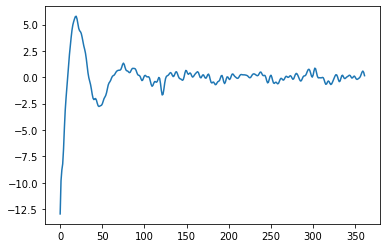

In [138]:
plt.plot(X.loc[:,0])

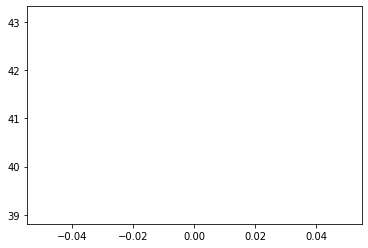

In [162]:
plt.plot(pcas[-1][0][0])

In [40]:
X= dm01.loc[:, censor_cols]
y1 = time_series[:,1]
lr = LinearRegression()
fitted = lr.fit(X,y1)
pred = fitted.predict(X)
residual1 = y1-pred

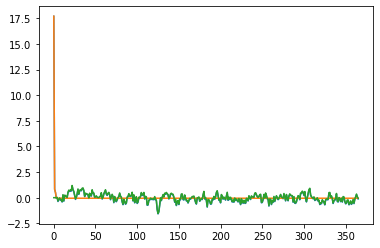

In [37]:
plt.plot(y)
plt.plot(pred)
plt.plot(residual)

In [39]:
X

,censor_000,censor_001,censor_002,censor_003
0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
361,0.0,0.0,0.0,0.0
362,0.0,0.0,0.0,0.0
363,0.0,0.0,0.0,0.0
364,0.0,0.0,0.0,0.0


In [11]:
time_series.shape

(366, 50)

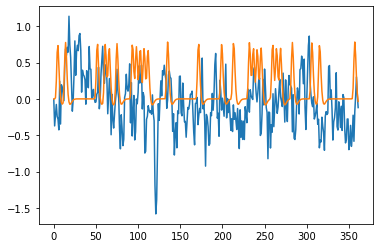

In [15]:
plt.plot(time_series[4:, 0])
plt.plot(dm01['neutral_anticipation'].values[4:])

In [23]:
dm01['anticipation_contrast'] = dm01['gain_anticipation'] - dm01['neutral_anticipation']
dm01['anticipation_convolved'] = np.convolve(dm01.anticipation_contrast, time_series[:,0])

ValueError: Length of values does not match length of index

In [26]:
np.multiply(dm01.anticipation_contrast, time_series[:,0]).shape

(366,)

In [23]:
roi_x = expand_mask(roi)

In [28]:
roi_x.data.shape
f = roi_x.plot()

threshold is ignored for simple axial plots


ValueError: Voxels are not isometric and cannot be visualized in standard space

In [27]:
view = plotting.view_img(roi_x.data)
view

TypeError: Data given cannot be loaded because it is not compatible with nibabel format:
0